# Calculates Circulation From Test Phase Profiles

In [1]:
import yt
import numpy as np
from abc import ABC

In [2]:
class CL_Analysis(ABC):
    def Theta(self, i, j, k):
        phi_1_Re, phi_1_Im, phi_2_Re, phi_2_Im = self.get_fields(i, j, k)
        theta = np.arctan2((phi_1_Im + phi_2_Re), (phi_1_Re - phi_2_Im))
        if theta < 0.0:
            theta = theta + 2.0 * np.pi
        return theta
    
    def DeltaTheta(self, ipl, jpl, kpl, il, jl, kl):
        # Returns Theta(ipl, jpl, kpl) - Theta(il, jl, kl)
        dtheta = self.Theta(ipl, jpl, kpl) - self.Theta(il, jl, kl)
        
        # Put dtheta into the range [-pi, 0] or [0, pi]
        if dtheta < -np.pi:
            dtheta += 2.0 * np.pi
        elif dtheta > np.pi:
            dtheta += -2.0 * np.pi

        return dtheta
    
    def Circulation(self, radius):
        center_i = int(self.domain_dimensions[0]/2)
        center_j = int(self.domain_dimensions[1]/2)
        center_k = int(self.domain_dimensions[2]/2)

        circulation = 0

        i_left = center_i - radius
        i_right = center_i + radius
        j_bottom = center_j - radius
        j_top = center_j + radius

        for j in range(self.domain_dimensions[1]):
            # Left side of loop except top left corner
            if j >= j_bottom and j < j_top:
                tdiff = self.DeltaTheta(i_left, j+1, center_k, i_left, j, center_k)
                print("adding ({}, {}): {}".format(i_left, j, tdiff))
                circulation += tdiff

            # Top left corner of loop
            elif j == j_top:
                tdiff = self.DeltaTheta(i_left+1, j, center_k, i_left, j, center_k)
                print("adding ({}, {}): {}".format(i_left, j, tdiff))
                circulation += tdiff
                
            # Right side of loop except bottom right corner
            if j > j_bottom and j <= j_top:
                tdiff = self.DeltaTheta(i_right, j-1, center_k, i_right, j, center_k)
                print("adding ({}, {}): {}".format(i_right, j, tdiff))
                circulation += tdiff
    
            # Bottom right corner of loop
            elif j == j_bottom:
                tdiff = self.DeltaTheta(i_right-1, j, center_k, i_right, j, center_k)
                print("adding ({}, {}): {}".format(i_right, j, tdiff))
                circulation += tdiff

        for i in range(self.domain_dimensions[0]):
            # Top and Bottom sides of loop except corners
            if i > i_left and i < i_right:
                tdiff = self.DeltaTheta(i+1, j_top, center_k, i, j_top, center_k)
                circulation += tdiff
                print("adding ({}, {}): {}".format(i, j_top, tdiff))

                tdiff = self.DeltaTheta(i-1, j_bottom, center_k, i, j_bottom, center_k)
                circulation += tdiff
                print("adding ({}, {}): {}".format(i, j_bottom, tdiff))

        circulation = circulation/(2.0 * np.pi)
        return circulation

In [3]:
class AMReX_CL_Data(CL_Analysis):
    def __init__(self, plotfile):
        self.ds = yt.load(plotfile)
        
        self.add_fields()
        
        cg = self.ds.covering_grid(left_edge=self.ds.domain_left_edge, dims=self.ds.domain_dimensions, level=0)
        coords = cg.fcoords
        
        self.domain_dimensions = self.ds.domain_dimensions

        xs = coords[:,0]
        ys = coords[:,1]
        ts = coords[:,2]

        self.dx = np.max(xs[1:] - xs[:-1])
        self.dy = np.max(ys[1:] - ys[:-1])
        self.dt = np.max(ts[1:] - ts[:-1])

        self.phi_1_Re = cg["phi_1_Re"][:,:,:].d
        self.phi_1_Im = cg["phi_1_Im"][:,:,:].d
        self.phi_2_Re = cg["phi_2_Re"][:,:,:].d
        self.phi_2_Im = cg["phi_2_Im"][:,:,:].d
        
    def add_fields(self):
        def _Phase(field, data):
            theta = np.arctan2((data[('boxlib', 'phi_1_Im')] + data[('boxlib', 'phi_2_Re')]), (data[('boxlib', 'phi_1_Re')] - data[('boxlib', 'phi_2_Im')]))
            theta = np.where(theta < 0.0, theta + 2.0 * np.pi, theta)
            return theta
        self.ds.add_field("Phase", function=_Phase, take_log=False, units="", display_name=r"Phase")

    def get_fields(self, i,j,k):
        return self.phi_1_Re[i,j,k], self.phi_1_Im[i,j,k], self.phi_2_Re[i,j,k], self.phi_2_Im[i,j,k]

## $\Gamma = +1$

Calculates the circulation for an initialization with unit circulation. The phase starts at $0$ in the lower left corner of each loop and increments by a full $2\pi$ around the loop.

yt : [INFO     ] 2020-03-20 08:25:36,067 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-03-20 08:25:36,071 Parameters: domain_dimensions         = [21 21 80]
yt : [INFO     ] 2020-03-20 08:25:36,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-03-20 08:25:36,079 Parameters: domain_right_edge         = [21. 21. 80.]
/home/eugene/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
yt : [INFO     ] 2020-03-20 08:25:36,460 xlim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:36,461 ylim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:36,462 xlim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:36,463 ylim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:36,470 Making a fixed resolution buffer of (('gas', 'Phase')) 800 by 800



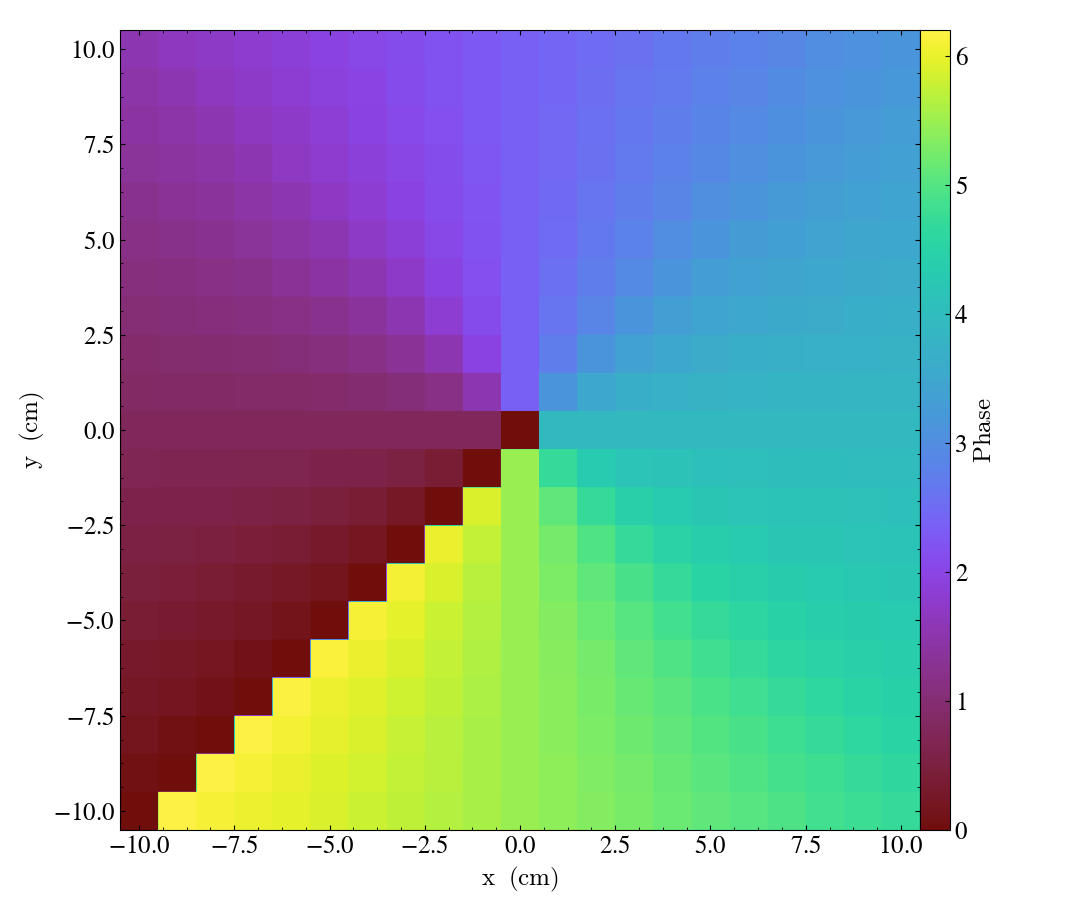

adding (8, 8): 0.39269908169872414
adding (12, 8): 0.3926990816987246
adding (8, 9): 0.39269908169872414
adding (12, 9): 0.3926990816987246
adding (8, 10): 0.39269908169872414
adding (12, 10): 0.39269908169872414
adding (8, 11): 0.39269908169872414
adding (12, 11): 0.39269908169872414
adding (8, 12): 0.39269908169872414
adding (12, 12): 0.3926990816987237
adding (9, 12): 0.39269908169872414
adding (9, 8): 0.3926990816987246
adding (10, 12): 0.39269908169872414
adding (10, 8): 0.3926990816987237
adding (11, 12): 0.39269908169872414
adding (11, 8): 0.3926990816987237

Circulation = 0.9999999999999999


In [4]:
amrex_cl = AMReX_CL_Data("problem_1/plt00000")

slc = yt.SlicePlot(amrex_cl.ds, 'z', 'Phase')
slc.show()

amrex_circ = amrex_cl.Circulation(2)
print("\nCirculation = {}".format(amrex_circ))

## $\Gamma = 0$

Calculates the circulation for an initialization with zero circulation but nonzero phase gradient. The phase starts at $0$ in the lower left corner of each loop and increments by a full $2\pi$ halfway around the loop. In the second half of the loop, the phase decrements by a full $2\pi$ to return to $0$.

yt : [INFO     ] 2020-03-20 08:25:37,322 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-03-20 08:25:37,323 Parameters: domain_dimensions         = [21 21 80]
yt : [INFO     ] 2020-03-20 08:25:37,324 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-03-20 08:25:37,326 Parameters: domain_right_edge         = [21. 21. 80.]
/home/eugene/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
yt : [INFO     ] 2020-03-20 08:25:37,718 xlim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:37,719 ylim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:37,720 xlim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:37,720 ylim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:37,723 Making a fixed resolution buffer of (('gas', 'Phase')) 800 by 800



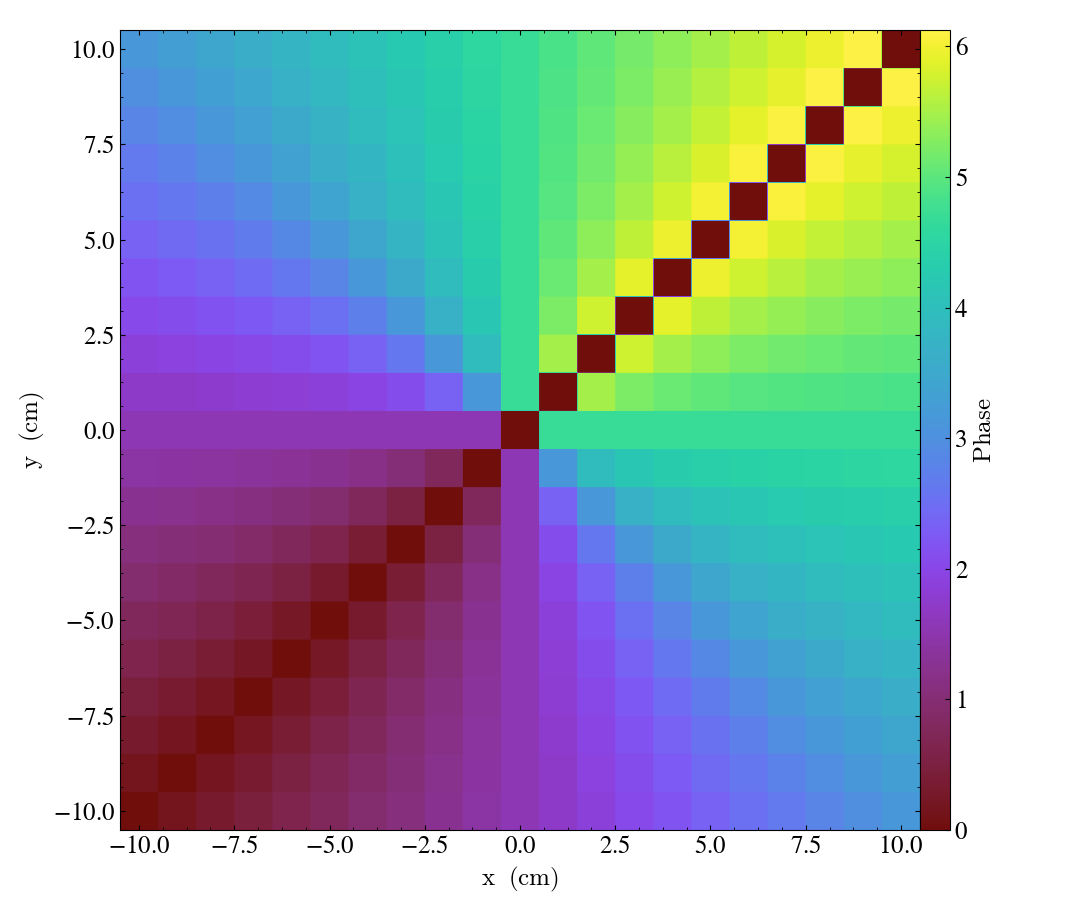

adding (8, 8): 0.7853981633974483
adding (12, 8): -0.7853981633974483
adding (8, 9): 0.7853981633974483
adding (12, 9): -0.7853981633974478
adding (8, 10): 0.7853981633974483
adding (12, 10): -0.7853981633974487
adding (8, 11): 0.7853981633974483
adding (12, 11): -0.7853981633974483
adding (8, 12): 0.7853981633974478
adding (12, 12): -0.7853981633974483
adding (9, 12): 0.7853981633974487
adding (9, 8): -0.7853981633974483
adding (10, 12): 0.7853981633974483
adding (10, 8): -0.7853981633974483
adding (11, 12): 0.7853981633974483
adding (11, 8): -0.7853981633974483

Circulation = 0.0


In [5]:
amrex_cl = AMReX_CL_Data("problem_2/plt00000")

slc = yt.SlicePlot(amrex_cl.ds, 'z', 'Phase')
slc.show()

amrex_circ = amrex_cl.Circulation(2)
print("\nCirculation = {}".format(amrex_circ))

## $\Gamma = -1$

Calculates the circulation for an initialization with negative unit circulation. The phase starts at $0$ in the lower left corner of each loop and increments by a full $-2\pi$ around the loop.

yt : [INFO     ] 2020-03-20 08:25:38,256 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-03-20 08:25:38,257 Parameters: domain_dimensions         = [21 21 80]
yt : [INFO     ] 2020-03-20 08:25:38,259 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-03-20 08:25:38,261 Parameters: domain_right_edge         = [21. 21. 80.]
/home/eugene/.local/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
yt : [INFO     ] 2020-03-20 08:25:38,672 xlim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:38,673 ylim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:38,674 xlim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:38,675 ylim = 0.000000 21.000000
yt : [INFO     ] 2020-03-20 08:25:38,683 Making a fixed resolution buffer of (('gas', 'Phase')) 800 by 800



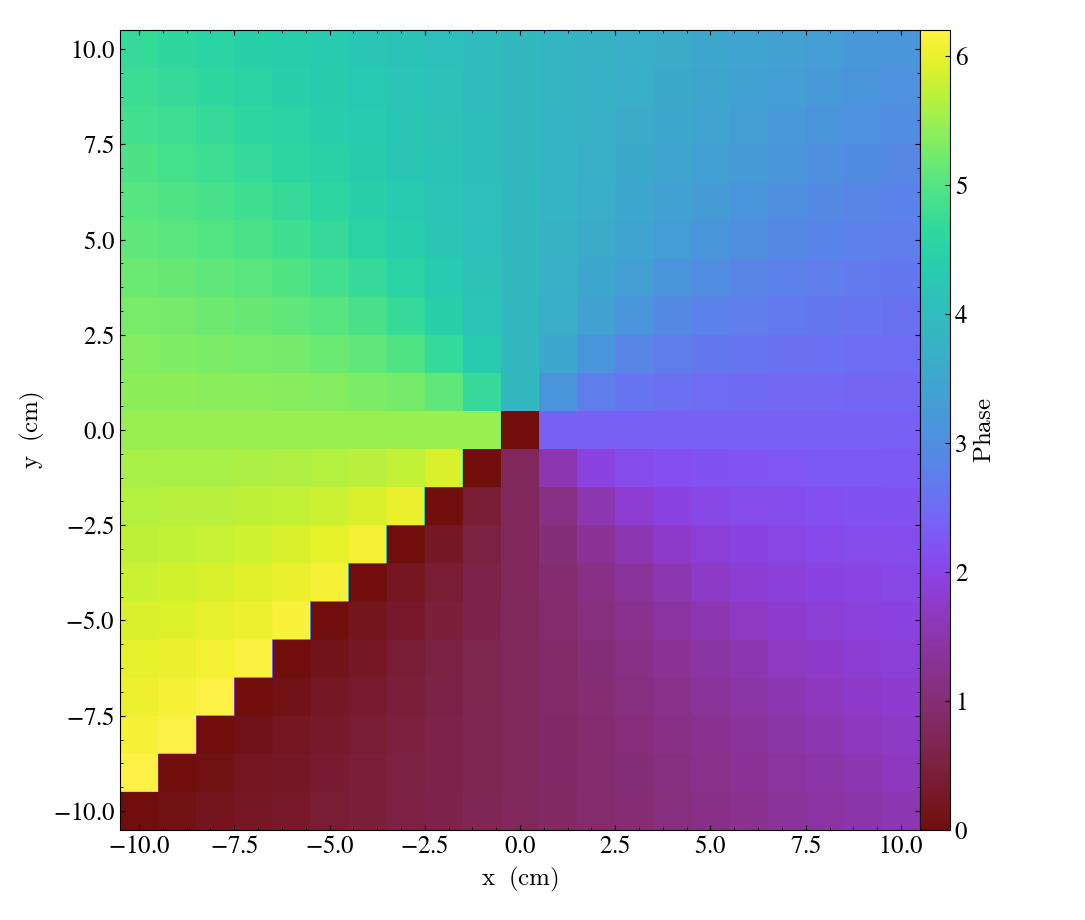

adding (8, 8): -0.3926990816987246
adding (12, 8): -0.39269908169872414
adding (8, 9): -0.3926990816987237
adding (12, 9): -0.39269908169872414
adding (8, 10): -0.3926990816987237
adding (12, 10): -0.39269908169872414
adding (8, 11): -0.3926990816987246
adding (12, 11): -0.39269908169872414
adding (8, 12): -0.3926990816987246
adding (12, 12): -0.39269908169872414
adding (9, 12): -0.39269908169872414
adding (9, 8): -0.3926990816987239
adding (10, 12): -0.39269908169872414
adding (10, 8): -0.39269908169872414
adding (11, 12): -0.3926990816987237
adding (11, 8): -0.39269908169872414

Circulation = -1.0


In [6]:
amrex_cl = AMReX_CL_Data("problem_3/plt00000")

slc = yt.SlicePlot(amrex_cl.ds, 'z', 'Phase')
slc.show()

amrex_circ = amrex_cl.Circulation(2)
print("\nCirculation = {}".format(amrex_circ))